## In this work, I focus on the attribute "number of days since the pop-up store opened"

In [1]:
import sqlite3
import pandas as pd
from statistics import stdev, mean
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
import math


In [2]:
# connect to splite database
con = sqlite3.connect("cafe_insomnia.sqlite")

In [3]:
# read three datasets as dataframe from sqlite
trans_pd = pd.read_sql_query("SELECT * from ci_transaction", con)
drink_pd = pd.read_sql_query("SELECT * from drink", con)
area_pd = pd.read_sql_query("SELECT * from study_area", con)
con.close()

## Give a fast preview of these datasets

In [4]:
trans_pd.describe()

,id,days_after_open,hours_after_open,drink_id,quantity,study_area_id
count,27714.000000,27714.000000,27714.000000,27714.000000,27714.000000,27714.000000
mean,13856.500000,107.558959,2.375947,8.030165,1.266905,2.166558
std,8000.487016,36.843121,1.681598,4.875940,0.613148,2.131795
min,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000
25%,6928.250000,89.000000,1.000000,4.000000,1.000000,0.000000
50%,13856.500000,117.000000,2.000000,8.000000,1.000000,1.000000
75%,20784.750000,136.000000,4.000000,12.000000,1.000000,4.000000
max,27713.000000,153.000000,5.000000,16.000000,4.000000,6.000000


In [5]:
drink_pd.describe()

,id,unit_price
count,17.000000,17.000000
mean,8.000000,4.200000
std,5.049752,0.586302
min,0.000000,3.300000
25%,4.000000,3.800000
50%,8.000000,4.000000
75%,12.000000,4.600000
max,16.000000,5.400000


In [6]:
area_pd.describe()

,id,dist_to_cafe
count,7.000000,7.000000
mean,3.000000,386.285714
std,2.160247,332.901244
min,0.000000,70.000000
25%,1.500000,117.000000
50%,3.000000,350.000000
75%,4.500000,550.000000
max,6.000000,950.000000


## Statistics for the cafe's business volume

In [7]:
# save drink price in table for quickly querying
drinks_table = {}
drink_kinds = {}

for index, row in drink_pd.iterrows():
    did = row['id']
    unit_price = row['unit_price']
    drinks_table[did] = unit_price
    drink_kinds[did] = row['name']

In [8]:
day_volume = {}
day_volume_drinks = {}

for idx, row in trans_pd.iterrows():
    # obtain day business volume
    day_spent = row['days_after_open']
    quality = row['quantity']
    drink = row['drink_id']
    unit_price = drinks_table[drink]
    if day_spent not in day_volume:
        day_volume[day_spent] = 0
    day_volume[day_spent] += unit_price * quality

    # obtain day business volume group by all kind of drinks
    if drink not in day_volume_drinks:
        day_volume_drinks[drink] = {}
    if day_spent not in day_volume_drinks[drink]:
        day_volume_drinks[drink][day_spent] = 0
    day_volume_drinks[drink][day_spent] += unit_price * quality

## Explore the ditribution of drinks' business volume in each day

<AxesSubplot:ylabel='Count'>

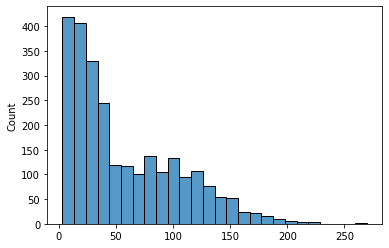

In [19]:
# draw the business volume distribution
series = []
day_volumes = []
for drink in day_volume_drinks:
    for day in day_volume_drinks[drink]:
        series.append(day_volume_drinks[drink][day])

for day in day_volume:
    day_volumes.append(day_volume[day])

days = list(day_volume.keys())
sns.histplot(series)

## Plot the trend of cafe's daily business volume

Text(85, 2079.8000000000006, '135th day')

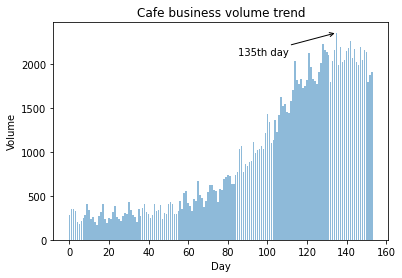

In [11]:
plt.bar(days, day_volumes, align='center', alpha=0.5)
plt.title('Cafe business volume trend')
plt.xlabel("Day")
plt.ylabel("Volume")

max_volume = max(day_volumes)
# label the day having maximum volume
arrowprops=dict(arrowstyle="->")
kw = dict(xycoords='data',textcoords="data", arrowprops=arrowprops, ha="left", va="bottom")
plt.annotate(str(day_volumes.index(max_volume)) + 'th day', xy=(day_volumes.index(max_volume), max_volume), xytext=(day_volumes.index(max_volume) - 50, max_volume - 280),  **kw)

As stated by the trend described by the above figure, it is evident that the Cafe's business volume keeps growing in a long term until the 135th day. After that, we found the volume gradually stabilized. To examine the reasons behind the result, we next explore what factors may affect the volume.

In [12]:
# get the volume grow rate in days
rates = []
avg_rates = []
volumes = list(day_volume.values())

for i in range(1, len(volumes)):
    rate = volumes[i] / volumes[i-1]
    rates.append(rate)

for i in range(len(rates) - 2):
    avg_rate = (rates[i] + rates[i+1] + rates[i+2]) / 3
    avg_rates.append(avg_rate)

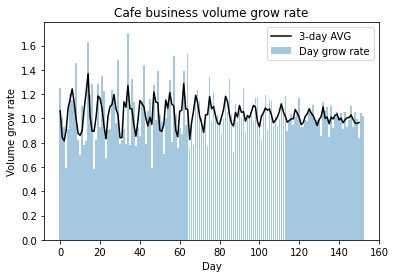

In [13]:
# plot the grow rate of business volume
day_dim = np.arange(len(rates))
plt.bar(day_dim, rates, alpha=0.4, label='Day grow rate')
plt.plot(avg_rates, color='black', label='3-day AVG')
plt.xlabel("Day")
plt.ylabel("Volume grow rate")
plt.title("Cafe business volume grow rate")
plt.legend()

Here, we also investigate the growth rate of the business volume these days. As shown in the above figure about growth rate change, we also see the growth rate keeps fluctuating decreasing, and finally approaching 0.

## Compute and plot the trend of day business volume group by different drinks

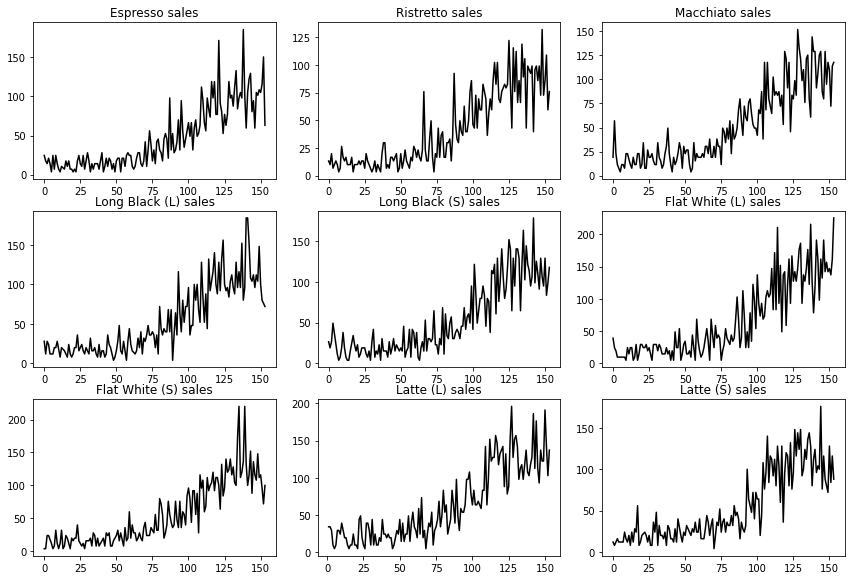

In [14]:
# draw the volume changes group by all kinds of drinks
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,8))
fig.tight_layout()
for idx, drink in enumerate(list(drink_kinds.keys())[0:9]):
    day_dim = day_volume_drinks[drink].keys()
    volumes = day_volume_drinks[drink].values()
    axes[int(idx/3)][idx%3].plot(day_dim, volumes, color='black')
    axes[int(idx/3)][idx%3].set_title(drink_kinds[drink] + ' sales')

To find whether there are special drinks that influence sales, we plot the business volume changes for these all kinds of drink types (the above cell show 9 of total 17 types). As a result, there is no special drinks hold total sales back, and the number of days since the pop-up store opened affect all the kinds of drinks' sales.

## Calculate and plot the trend of business volume group by different areas

Text(0.5, 1.0, 'Cafe business volumes in area 2')

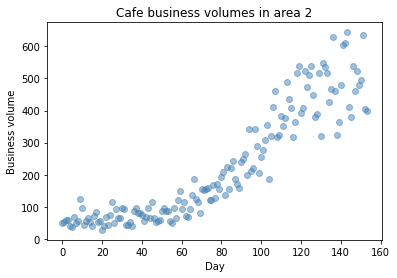

In [15]:
area_group = dict()

for index, row in trans_pd.iterrows():
    # compute sales of each day
    day_spent = row['days_after_open']
    quality = row['quantity']
    aid = row['study_area_id']
    unit_price = drinks_table[drink]
    if aid not in area_group:
        area_group[aid] = {}
    if day_spent not in area_group[aid]:
        area_group[aid][day_spent] = 0
    area_group[aid][day_spent] += unit_price * quality

days_volume_area = []
day_dims = []

for day in area_group[1]:
    days_volume_area.append(area_group[1][day])
    day_dims.append(day)

plt.scatter(day_dims, days_volume_area, alpha=0.5, color='steelblue')
plt.xlabel("Day")
plt.ylabel("Business volume")
plt.title("Cafe business volumes in area 2")

To examine whether the sale areas influence the total business volume, here we plot the business volume changes in different regions (the above visualization only shows one of them), we find the sales trends are also similar in different regions. The result indicated that the number of days since the pop-up store opened influence all the regions' drink sales.

## Compute and plot the day business volumes at different weathers

Text(0.5, 1.0, 'Weather condition')

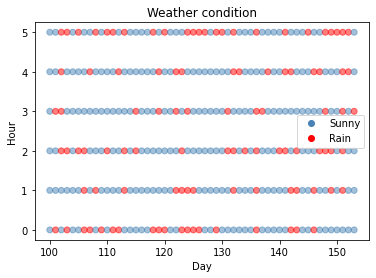

In [16]:
weather_group = {}
weather_mat = []

for idx, row in trans_pd.iterrows():
    # caculate day business volumes
    day_spent = row['days_after_open']
    hour_spent = row['hours_after_open']

    if day_spent not in weather_group:
        weather_group[day_spent] = {}
    if hour_spent not in weather_group[day_spent]:
        weather_group[day_spent][hour_spent] = {'rain':0, 'sunny':0}
    if row['raining'] == 'Yes':
        weather_group[day_spent][hour_spent]['rain'] += 1
    elif row['raining'] == 'No':
        weather_group[day_spent][hour_spent]['sunny'] += 1

# reorganize the volume data
for day in weather_group:
    for hour in weather_group[day_spent]:
        label = weather_group[day][hour]['rain'] > weather_group[day][hour]['sunny']
        weather_mat.append({'day': day, 'hour': hour, 'weather': label})
weather_df = pd.DataFrame(weather_mat) 

# plot the weather condition
cmap = colors.LinearSegmentedColormap.from_list("", ["steelblue", "red"])
index = 100*6
fig, ax = plt.subplots()
scatter = ax.scatter(weather_df['day'][index:], weather_df['hour'][index:], 
    c=weather_df['weather'][index:], cmap=cmap, alpha=0.5)

legend_markers = [Line2D([0], [0], marker='o', lw=0, color='steelblue', label='Sunny'),
                   Line2D([0], [0], marker='o', lw=0, color='red', label='Rain')]

ax.legend(handles=legend_markers)
ax.set_xlabel("Day")
ax.set_ylabel("Hour")
ax.set_title("Weather condition")

To find out the reasons why the volume growth rate stabilized after the 135th day, we plot all the weather conditions at each hour of each day after the 100th day. It is clear that there is no continuous bad weather during these days. We can say the weather condition does not influence the macro trend of drink sales.

In [17]:
# get the correlation coefficient between day number and business volume via Pearsons'

days = day_volume.keys()
volumes = day_volume.values()

# Covariance computing function
def cov(X, Y):
    sum = 0
    for i in range(len(X)):
        d = (X[i] - mean(X)) * (Y[i] - mean(Y))
        sum += d
    sum *= 1/(len(X)-1)
    return sum

# Pearson correlation computing function
def corr(X, Y):
    return cov(X, Y) / (stdev(X) * stdev(Y))

cc = corr(list(days), list(volumes))

print('Pearsons coefficient: %.3f' % cc)

Pearsons coefficient: 0.932


Here, we calculate the Pearson's correlation coefficient between day numbers and business volumes to reconfirm the correlation between them. We got a 0.932 score for the correlation coefficient, which indicates there is a high correlation between day numbers and business volumes.

## Further work

According to the explorative analysis, we found the business volume keeps growing because the cafe got gradually being exposed in the early stage, and also bringing in many fresh customers. However, when the exposure reaches its peak, the volume growth rate slowly approaching 0. We also explore the reasons behinds the volume changes, but the region, weather, and drink type do not influence the macro trend of business volume. In the end, we can say the attribute “number of days since the pop-up store opened” influence the drink sales, but it may not affect the drink sales in the future because the shop exposure has converged. Hence, for the sales prediction, I don’t recommend take this attribute into consideration.